# Approximative Zwischenergebnisse des Nowcastings aus dem RKI Situationsbericht

Thomas Viehmann, <tv@lernapparat.de>

Hier extrahieren wir die Zahlen für Bekannte/Imputierte/Nowcast-Fälle aus den Situationsberichten.

Bitte beachten Sie die Datenlizenz für die RKI Daten.

In [16]:
import collections
import bs4
import pandas
%matplotlib inline
from matplotlib import pyplot
import math
import numpy
import re
import datetime

Ausgangspunkt ist die SVG-Convertierte Seite mit der Nowcasting grafik aus dem Situationsbericht:

https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/Gesamt.html

Die kann man z.B. durch `pdf2svg 2020-05-16-de.pdf 2020-05-16-de.svg 7` oder mit Inkscape bekommen.
Das ganze habe ich an einigen Tagen ausprobiert, es ist möglicherweise aber nicht stabil, weil es die "unendlichen Möglichkeiten" des SVG-Formats nicht abbildet.

Wir benutzen die vom RKI veröffentlichten Nowcasting-Zahlen des RKI, um die Skalierung zu berechnen (eleganter, da eigenständiger wäre natürlich, eine Horizontale Achse (z.B. 4000) im Graphen zu suchen.

https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting.html

Den Verlauf nehmen wir auch gleich zur Kontrolle.

Hier sind die Dateinamen:

In [226]:
fn_nowcasting_excel = 'Nowcasting_Zahlen.2020-05-17.xlsx'
fn_svg_from_report = '/tmp/2020-05-17-de.svg'
fn_output = './nowcast_imputed_known_from_graph_2020-05-17.csv'

Erst mal die Tabelle auslesen:

In [311]:
rki_numbers = pandas.read_excel(fn_nowcasting_excel, sheet_name='Nowcast_R', index_col=0)
nowcasting_excel = rki_numbers.iloc[:, 3]
assert nowcasting_excel.name.startswith('Punkts')
max_from_excel = nowcasting_excel.max()
max_from_excel # should be around 5331, but does vary (presumably due to stochastic imputation)

5330

Das extrahieren der Zahlen ist sehr ad-hoc. Wir finden mit den passenden Farben gefüllte `path`-Elemente und versuchen einen improvisierten Parser für die Bewegungen und merken uns die minimalen und maximalen x und y Koordinaten "der Balken".

In [325]:
root = bs4.BeautifulSoup(open(fn_svg_from_report))
fill_re = re.compile('fill:rgb|fill:#')
lookfor = {(21, 48, 64) : 'known', (56, 72, 85): 'nowcast', (70, 70, 70) : 'imputed',
           'fill:#367ba4': 'known', 'fill:#b3b3b3': 'imputed', 'fill:#90bad9': 'nowcast'}
paths_with_fill_style = [p for p in root.find_all('path') if fill_re.search(p.get('style',''))]

values = collections.defaultdict(list)
for p in paths_with_fill_style:
    fill_style = [s.strip() for s in p['style'].split(';') if fill_re.match(s) is not None][0]
    if 'rgb' in fill_style:
        rgb = tuple(int(float(s)) for s in re.match(r"fill:rgb\(([0-9\.]+)%,([0-9\.]+)%,([0-9\.]+)%\)", fill_style).groups())
    else:
        rgb = fill_style.strip()
    key = lookfor.get(rgb)
    if key is not None:
        movements = re.split('[, ]+', p['d'].strip())
        i = 0
        ymin = math.inf
        ymax = -math.inf
        xmax = -math.inf
        xmin = math.inf
        while i < len(movements):
            v = movements[i]
            if v in {'M', 'L', 'm'}:
                x = float(movements[i + 1])
                y = float(movements[i + 2])
                i += 3
            elif v in {'Z', 'z'}:
                i += 1
            elif v == 'h':
                x += float(movements[i+1])
                i += 2
            elif v == 'H':
                x = float(movements[i+1])
                i += 2
            elif v == 'v':
                y += float(movements[i+1])
                i += 2
            elif v == 'V':
                y = float(movements[i+1])
                i += 2
            else:
                raise Exception(f"need to parse more path: {i}, {v}")
            xmin = min(xmin, x)
            ymin = min(ymin, y)
            ymax = max(ymax, y)
            xmax = max(xmax, x)
        values[key].append((xmin, ymin, ymax))

Jertzt haben wir zu viel: mindestens mal aus der Legende bekommen wir "Irrläufer". Wir ermitteln eine "Grundlinie", die "fast alle" Pfade als Minimale/Maximale y-Ausdehnung haben. Ich kenne mich mit SVG nicht aus, aber ich habe den Eindruck, dass das Koordinatensystem sowohl unten als auch oben kleine y-Werte kann, deshalb checkt das Skript beides. Dann behalten wir nur Pfade, die auf der Grundline liegen.

In [326]:
values = dict(values)
for k, v in values.items():
    vals = numpy.array(sorted(v))
    # drop legend
    p25 = numpy.percentile(vals, 25, axis=0)
    p75 = numpy.percentile(vals, 75, axis=0)
    iqr = p75-p25
    if iqr[1] < 1:
        values[k] = numpy.array([(x, ymax - ymin) for x, ymin, ymax in sorted(v) if numpy.abs(ymin-p75[1]) < 1])
    elif iqr[2] < 1:
        values[k] = numpy.array([(x, ymax - ymin) for x, ymin, ymax in sorted(v) if numpy.abs(ymax-p75[2]) < 1])
    else:
        raise Exception('Need xmin or xmax to vary little')
    print(k, len(vals), len(values[k]))


nowcast 86 85
imputed 86 85
known 85 84


Es scheint möglich, dass Werte (am Anfang?) fehlen. Also basteln wir Indizes aus der x-Position und füllen Leerstellen durch Nullen auf.

In [327]:
xes = set()
for v in values.values():
    xes |= {int(10*x) for x in v[:, 0]}
xdict = {v: i for i,v in enumerate(sorted(xes))}

for k, v in values.items():
    new_v = numpy.zeros(len(xdict))
    for x, h in v:
        new_v[xdict[int(10*x)]] = h
    values[k] = new_v
len(xdict)

85

Jetzt skalieren wir alles mit dem Maximum und schon können wir graphen machen.

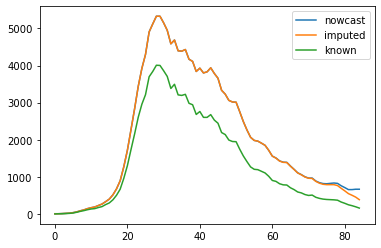

In [338]:
mult = max_from_excel / values['nowcast'].max()

for k, v in values.items():
    v *= mult
    pyplot.plot(values[k], label=k)

pyplot.legend()
pyplot.savefig(fn_output+'.svg')
pyplot.show()


Dann machen wir einen Dataframe. Wir gehen davon aus, dass der Graph und die Nowcasting-Tabelle am selben Tag enden.

In [333]:
end_date = nowcasting_excel.index.max()
idx = pandas.date_range(end_date - pandas.Timedelta(len(values['nowcast'])-1, unit='D'), end_date, name='Refdatum')
df = pandas.DataFrame(values, index=idx)

Vergleichen wir noch mit den Excel-Zahlen. Ich bekomme Abweichungen von 0-4.

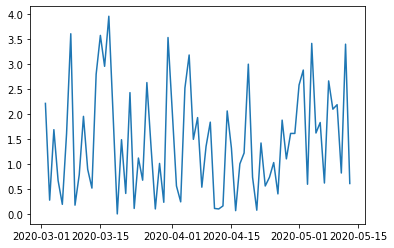

In [334]:
pyplot.plot((nowcasting_excel - df.nowcast).dropna().abs())

Wenn alles gut aussieht, sind wir fertig. Wir schreiben die Ergebnisse in ein CSV.

In [336]:
df.to_csv(fn_output)